Predicting Stock Prices Using LSTM: An Analysis of Time Series Data

This project explains how to develop an end-to-end data science model using Alpha Vantage APIs and Long Short-Term Memory (LSTM) machine learning algorithms for predicting stock price movements. As a result of completing this project, you will learn the key concepts of machine learning / deep learning and build a fully functional stock market prediction model in Python.

Due to the inherent complexity and uncertainty of financial markets, predicting stock prices has always been challenging. Advances in deep learning techniques, such as Long Short-Term Memory (LSTM) neural networks, have shown promise in capturing temporal patterns and making accurate predictions. Using historical data, we apply LSTM models to predict stock prices. To understand the performance of the model, we use a comprehensive approach that includes data preprocessing, model training, and evaluation.

In [1]:
#@title Load Python libraries

! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

     |████████████████████████████████| 1.3MB 16.0MB/s 
     |████████████████████████████████| 296kB 50.6MB/s 
     |████████████████████████████████| 143kB 48.5MB/s 
All libraries loaded


For further operations, this code loads several Python libraries. 

Using the pip package manager, the first line installs the "alpha_vantage" library. Financial data, specifically stock market data, can be accessed through this library. The `-q` flag makes the installation process quiet, so it doesn't display unnecessary output. The code then imports several libraries. The libraries are numpy, torch, torch.nn, torch.nn.functional, torch.optim, torch.utils.data, matplotlib.pyplot, and matplotlib.pyplot.figure. Each library serves a different purpose in data analysis and machine learning.

The `import numpy as np` statement imports the numpy library and assigns it the alias "np." Numpy is a powerful library for numerical computations and provides efficient data structures and functions.

The `import torch` statement imports the torch library, which is a popular deep learning framework. It provides functionalities for building and training neural networks.  The `import torch.nn as nn` statement imports the torch.nn module, which contains classes for creating neural network layers and architectures.  The `import torch.nn.functional as F` statement imports the torch.nn.functional module, which contains various activation functions and other operations commonly used in neural networks.  The `import torch.optim as optim` statement imports the torch.optim module, which provides This statement imports the Dataset class from the torch.utils.data module, which implements optimization algorithms for training neural networks. This class is used for creating custom datasets to feed into neural networks. The torch.utils.data module contains the DataLoader class. This class is used for loading and batching data from a dataset during the training process. It imports the pyplot module from matplotlib. This module provides functions for creating visualizations, such as plots and charts. It imports the figure function from the pyplot module. This function is used to create a figure object that can be customized for plotting. It imports the TimeSeries class from alpha_vantage.timeseries. This class allows fetching historical stock market data using the Alpha Vantage API. Upon importing the libraries, it prints the message "All libraries loaded.".

In [2]:
config = {
    "alpha_vantage": {
        "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

This code defines a configuration dictionary with various settings and parameters for a data analysis and modeling task. The "alpha_vantage" key refers to the Alpha Vantage API, which provides financial market data. The API key can be obtained from Alpha Vantage's website, as well as the symbol of the stock (in this instance, "IBM"), the desired output size ("full" for all available data), and the adjusted closing price key. Data processing parameters are defined under the "data" key in the dictionary. The window size determines the number of previous data points that will be considered for prediction, while the train split size determines the proportion of data that will be used to train the model. Parameters related to visualizations are defined in the dictionary under the "plots" key. It specifies whether to show plots, the interval of x-axis ticks on the plots, and the colors for different elements of the plots, such as actual data, training data, validation data, and predicted data.

The dictionary sets parameters for neural networks under the "model" key. It includes the input size (1 in this case, as only the closing price is used as a feature), the number of LSTM layers, the size of each LSTM layer, and the dropout rate for regularization. Training parameters are listed under the "training" key. It specifies the device to be used for training ("cpu" or "cuda" for GPU), the batch size for training data, the number of epochs (iterations) for training, the learning rate for the optimizer, and the step size for the learning rate scheduler.

This configuration dictionary organizes all these settings and parameters into a single document, allowing it to be easily modified in the code to accommodate a variety of scenarios, making it more flexible and customizable.

Obtaining financial market data from Alpha Vantage for data preparation

Number data points: 5417 from 1999-11-01 to 2021-05-12


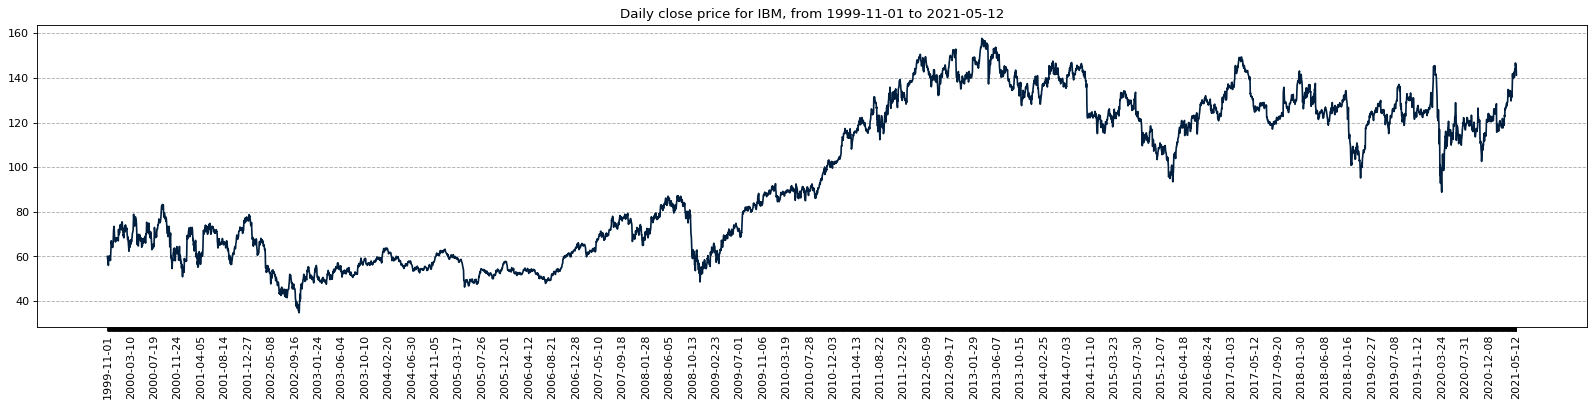

In [3]:
def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range

data_date, data_close_price, num_data_points, display_date_range = download_data(config, plot=config["plots"]["show_plots"])

Using the Alpha Vantage API, the code defines a function called "download_data" that downloads and processes financial market data. It takes two parameters: "config," a dictionary containing various settings and parameters, and "plot," a boolean flag indicating whether a plot should be generated. A key and symbol specified in the configuration are used to fetch the data from the Alpha Vantage API within the function. This is accomplished using the "TimeSeries" class from the "alpha_vantage.timeseries" module. The retrieved data is stored in the "data" variable, and additional metadata about the data is stored in the "meta_data" variable. Next, the function processes the data. To ensure chronological order, it first extracts the dates from the data and reverses the order. The reversed dates are stored in the "data_date" list. The function then extracts the adjusted closing prices. Using the "data_close_price" list, it retrieves the corresponding values for each date and converts them to floating-point numbers. The list is then converted into a numpy array for further processing. To determine the number of data points, the length of the "data_date" list is obtained. It also creates a string called "display_date_range" that represents the range of dates in the data, using the first and last dates from the "data_date" list. The function generates a plot if the "plot" parameter is set to True. The program creates a figure object with customized dimensions and background colors. Using the colors specified in the configuration, the function plots the dates on the x-axis and the closing prices on the y-axis. The x-axis ticks are also adjusted to display dates within a selected interval. A number of variables are returned by the function: "data_date," a list of dates; "data_close_price," a numpy array containing adjusted closing prices; "num_data_points," the number of data points in the dataset; and "display_date_range," a string identifying the range of dates. You can download financial market data, process it, and analyze it by calling this function and providing a configuration. Visualize it using a plot if you wish. Further analysis or modeling can be done with the returned data.

Preparation of raw financial data: normalization

In [4]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

For normalizing data, this code defines a class called "Normalizer". 

The class has three methods: __init__(), fit_transform(), and inverse_transform(). __init__() initializes the class and sets the attributes "mu" and "sd" to None. These attributes will be used to store the mean and standard deviation of the data. The fit_transform() method normalizes the input array, "x". The numpy functions np.mean() and np.std() are used to calculate the mean and standard deviation of the data along the 0th axis (columns). The calculated mean and standard deviation are stored in the "mu" and "sd" attributes of the class, respectively. Data is then normalized by subtracting the mean and dividing by the standard deviation. The normalized data is returned as "normalized_x". Inverse_transform() performs the inverse normalization of a normalized data array, "x". To obtain the original scale of the data, it multiplies the normalized data by the standard deviation. The inverse-transformed data is returned. An instance of the "Normalizer" class is created outside the class. This instance can be used to normalize data using the fit_transform() method. After applying the fit_transform() method to the data_close_price array, the normalized data is stored in the normalized_data_close_price variable. The "data_close_price" array is passed as input to the fit_transform() method, which calculates the mean and standard deviation of the data and performs the normalization process. As a result of this code, you can normalize data to a standard scale before using it for various data analysis or machine learning tasks.

Preparation of training and validation datasets

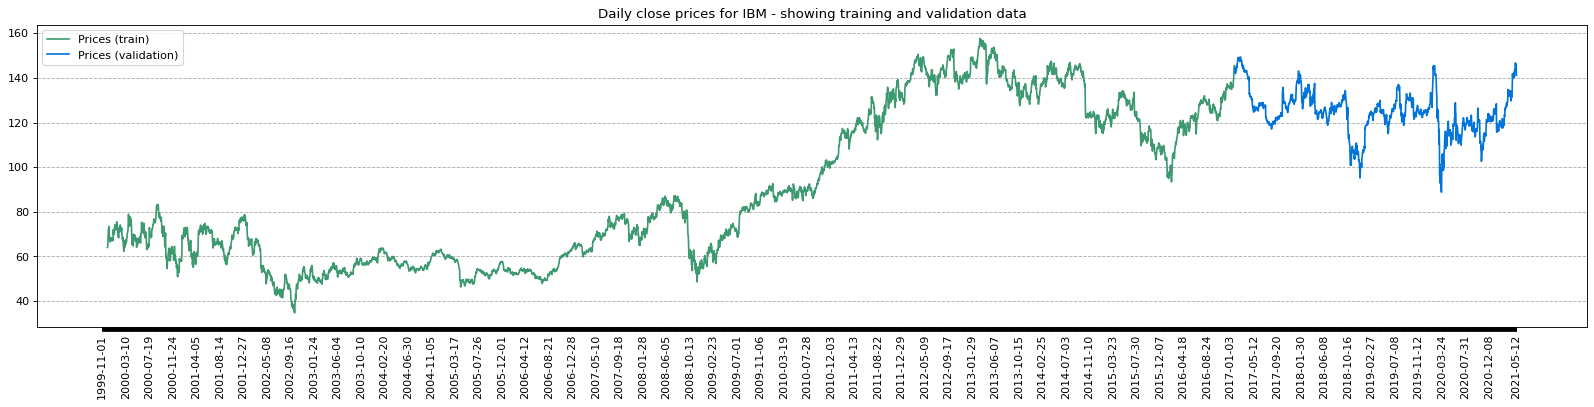

In [5]:
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row,window_size), strides=(x.strides[0],x.strides[0]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, config, plot=False):
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # split dataset

    split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]

    if plot:
        # prepare data for plotting

        to_plot_data_y_train = np.zeros(num_data_points)
        to_plot_data_y_val = np.zeros(num_data_points)

        to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
        to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

        to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
        to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

        ## plots

        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
        plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(normalized_data_close_price, config, plot=config["plots"]["show_plots"])

As a result of this code, the data can be prepared for a forecasting task based on a given configuration using a set of functions. In the first function, "prepare_data_x," a windowing operation is performed on the input array, "x." Based on the difference between the number of rows in "x" and the window size, it calculates the number of rows in the output array. Then, using the numpy function "as_strided," a new array is created with a sliding window of "window_size" over "x." The function returns two arrays: the windowed data without the last row and the windowed data with the last row. In the second function, "prepare_data_y," the forecasting target values are prepared. The input data array, "x," and the window size are required. In this case, it simply selects the values from "x" starting from the "window_size" index and returns them as the output array. In "prepare_data," the input and target data are prepared for training and validation. It takes the normalized data of the closing prices, the configuration dictionary, and a flag indicating whether plots should be generated. As a result of the "prepare_data_x" function, it generates two windowed input data arrays, "data_x" and "data_x_unseen." The sliding window size is determined by the configuration. 

By selecting the corresponding target values based on the window size, the "prepare_data_y" function generates the target data array, "data_y." As specified in the configuration, this function divides the dataset into training and validation sets. The split index is calculated as a proportion of the number of target values, and the input and target data are split accordingly. When the plot flag is set to True, the function generates a plot of training and validation data. Using the "inverse_transform" method of the "Normalizer" class, it inverse-transforms the target values for plotting. Using the colors specified in the configuration, it creates a figure, sets the dimensions, and plots training and validation data. An interval of dates is selected for the x-axis ticks. In addition, the function returns a number of variables: "split_index," which represents the index where the dataset is divided into training and validation sets; "data_x_train" and "data_y_train," which represent the inputs and targets for the training set; "data_x_val" and "data_y_val," which represent the inputs and targets for the validation set; and "data_x_unseen," which represents the windowed input data for unseen predictions. By calling this function and providing the necessary inputs, you can prepare the data for forecasting, splitting it into training and validation sets, and visualizing it if desired. Training and evaluating a model can be done with the returned variables.

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (4317, 20, 1) (4317,)
Validation data shape (1080, 20, 1) (1080,)


As a result of this code, the class "TimeSeriesDataset" is defined for time series analysis and forecasting. PyTorch's "Dataset" class is inherited from the class, which provides a standard interface for accessing and manipulating datasets. The class takes two arguments into account when it calls the "__init__" method: "x" and "y," which represent the input and target data for the time series analysis. By using the "np.expand_dims" function, "x" is expanded by adding a new dimension at axis 2. For LSTM models, the input shape should be [batch, sequence, features] because the data only has one feature. Input and target data are then stored in the class attributes "self.x" and "self.y," respectively. By using the "__len__" method, the dataset length is returned, which corresponds to the length of the input data "x." The "len" function allows easy access to the dataset size. To retrieve an item from a dataset at a specified index "idx," the "__getitem__" method returns a tuple containing the input data and the corresponding At that index, the code creates two instances of the "TimeSeriesDataset" class outside the class: "dataset_train" and "dataset_val." These instances are initialized with the training and validation inputs and target data, respectively.  Finally, the code prints the shapes of the training and validation data using the "x" and "y" attributes of the dataset instances. This provides information about the dimensions of the input and target data arrays. A custom dataset class, "TimeSeriesDataset," is defined in this code to represent time series data for analysis and forecasting. Using a specific index, it retrieves input and target data and provides access to individual items in the dataset.

The LSTM model is defined

In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

A time series forecasting model based on Long Short-Term Memory (LSTM) is defined in this code as "LSTMModel". This class inherits the PyTorch "nn.Module" class, which is the base class for all neural network modules. It takes several arguments to initialize the neural network model in the "__init__" method. Among them are the input size, the hidden layer size, the number of LSTM layers, the output size, and the dropout rate. The input size represents the number of features in the input data, while the hidden layer size determines the number of units in the LSTM layers. The model's architecture is defined in the "__init__" method. There is a linear layer, an activation function (ReLU), an LSTM layer, a dropout layer, and another linear layer. The linear layers are used for transforming the input data, and the LSTM layer is responsible for learning temporal patterns in the data. Initializing the LSTM layer's weights is done using the "init_weights" method. According to the parameter name, it iterates over the LSTM layer parameters and applies specific weight initialization techniques. For example, biases are set to zero, normal initialization is applied to input weights, and orthogonal initialization is applied to recurrent weights. Model forward passes are defined by the "forward" method. As an argument, it takes a tensor, "x." After passing through the linear layer, the input tensor is activated by the ReLU. The tensor is then passed through the LSTM layer, which generates the hidden and cell states. Through the dropout layer, the output is reshaped to have dimensions [batch, features]. To obtain the predictions, the output is passed through the last linear layer. The predictions are returned, taking only the last element of the output tensor. An instance of the "LSTMModel" class is created outside the class. The configuration is used to specify the input size, hidden layer size, number of LSTM layers, and dropout rate. Once the configuration is complete, the model is moved to the GPU or CPU specified in the configuration. This allows for utilizing hardware acceleration during the training process. To summarize, this code defines a custom LSTM model. The model is configured, the weights of the LSTM layer are initialized, the forward pass logic is defined, and a model instance is created. In the next step, the model is transferred to the specified device for further training and evaluation.

Training with models

In [8]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))


Epoch[1/100] | loss train:0.050537, test:0.001879 | lr:0.010000
Epoch[2/100] | loss train:0.010868, test:0.001240 | lr:0.010000
Epoch[3/100] | loss train:0.009598, test:0.001956 | lr:0.010000
Epoch[4/100] | loss train:0.008986, test:0.001376 | lr:0.010000
Epoch[5/100] | loss train:0.008774, test:0.001042 | lr:0.010000
Epoch[6/100] | loss train:0.009519, test:0.001311 | lr:0.010000
Epoch[7/100] | loss train:0.007898, test:0.001013 | lr:0.010000
Epoch[8/100] | loss train:0.007705, test:0.001066 | lr:0.010000
Epoch[9/100] | loss train:0.008269, test:0.001146 | lr:0.010000
Epoch[10/100] | loss train:0.007613, test:0.001178 | lr:0.010000
Epoch[11/100] | loss train:0.008015, test:0.001181 | lr:0.010000
Epoch[12/100] | loss train:0.007816, test:0.001232 | lr:0.010000
Epoch[13/100] | loss train:0.007499, test:0.002633 | lr:0.010000
Epoch[14/100] | loss train:0.008146, test:0.001044 | lr:0.010000
Epoch[15/100] | loss train:0.007939, test:0.001271 | lr:0.010000
Epoch[16/100] | loss train:0.00865

This code contains several functions and a training loop to train an LSTM model for a time series forecasting task. During training or evaluation, the "run_epoch" function is used. A dataloader provides batches of data, and a flag "is_training" indicates if it is a training or evaluation period. 

Inside the function, an epoch_loss variable is initialized to keep track of the loss accumulated during the epoch. The model is then set to training mode by using "model.train()". "model.eval()" sets it to evaluation mode otherwise. These modes affect how certain layers, such as dropout, behave during training and evaluation. Afterward, the dataloader loops over the batches. If it is a training epoch, the optimizer's gradients are zeroed using "optimizer.zero_grad()". The input data, "x," and target data, "y," are retrieved from the batch. They are then moved to the device specified in the configuration using ".to(config["training"]["device"]). This ensures that the data is processed on the correct hardware (CPU or GPU). The output is then obtained by calling the model with the input data, "x.". The loss between the output and the target data is calculated using the specified loss function, "criterion".  When it is a training epoch, the loss propagates backward through the model and the optimizer's step functions are called to update the model's parameters with "loss.backward()" and "optimizer.step()".  The batch loss is accumulated to the epoch_loss variable, taking into account the batch size.  The learning rate for the epoch is obtained from the learning rate scheduler using A training and validation dataloader is created using the training and validation datasets. An optimizer, scheduler, and loss function are defined outside the function. In the configuration, the model's parameters and learning rate are specified in the Adam optimizer. Based on the specified step size and gamma value, the scheduler adjusts the learning rate. The loss function is the mean squared error (MSE loss). In the training loop, the for loop iterates over the number of epochs specified. On the training and validation dataloaders, the "run_epoch" function is used to compute the loss and learning rate for each epoch. This code sets up the training process for the LSTM model. The loss values and learning rates are printed to track the progress of training. The step function of the learning rate scheduler is called to update the learning rate. The function defines a function that runs a single epoch of training or evaluation, creates dataloaders for training and validation data, initializes an optimizer, scheduler, and loss function, and executes the training loop. Every epoch, the model is trained on the training data and evaluated on the validation data, and the loss values are printed to monitor the training process.

Evaluation of the model

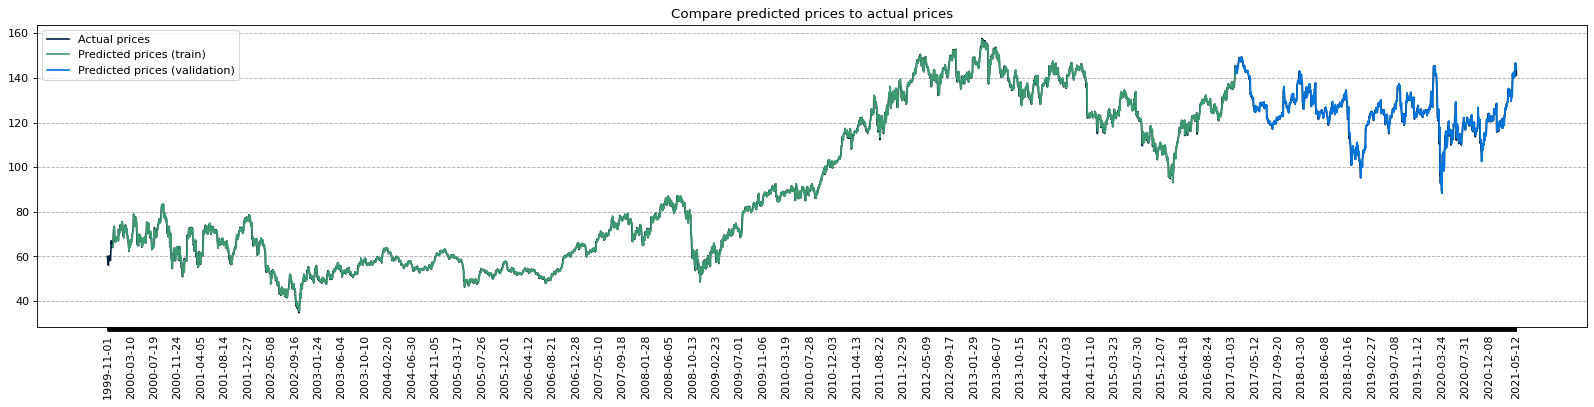

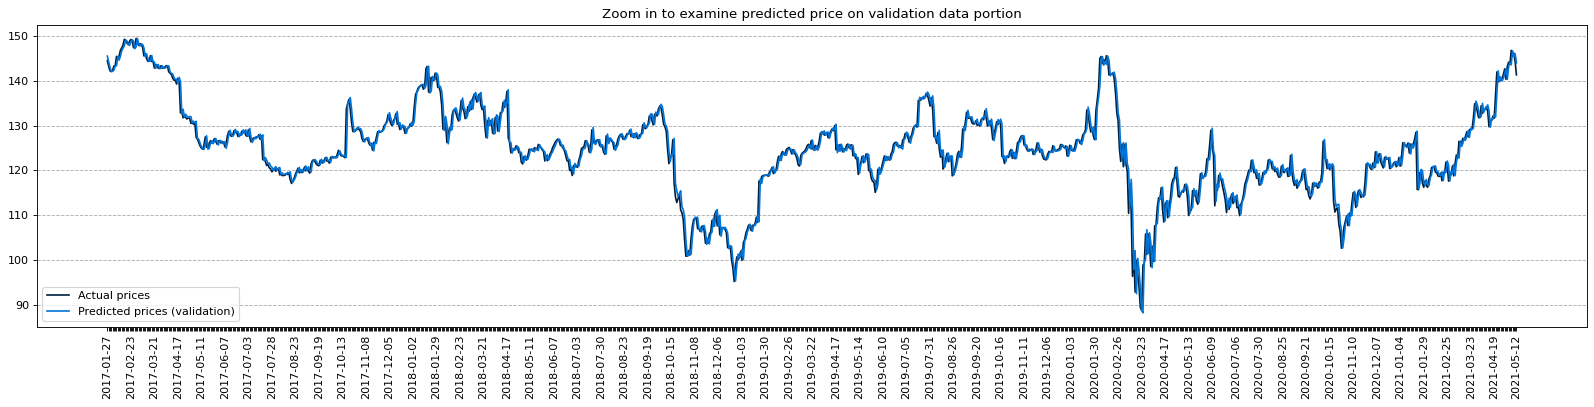

In [9]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation

    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val)
    to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Zoom in to examine predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

This code performs predictions using the trained LSTM model and generates plots to compare the predicted prices with the actual prices. Dataloaders for training and validation are re-initialized without moving data. A model is set to evaluation mode by using "model.eval()" to deactivate certain layers, such as dropout, that behave differently during training and evaluation to ensure that the order of the data is preserved for plotting purposes.

The code then performs predictions on the training data by iterating over the batches in the training dataloader. To obtain predictions, the input data, "x," is moved to the device specified in the configuration, and the model is called with the input data. The predictions are converted to a numpy array and concatenated with the previous predictions. The validation dataloader iterates over batches to perform predictions. Input data is moved to the device, and predictions are obtained using the model. When the "show_plots" flag in the configuration is set to True, the code generates plots to compare the predicted prices with actual prices. Again, the predictions are converted to a numpy array and concatenated. The data for plotting is first prepared by inverse-transforming the predicted prices using the "inverse_transform" method of the "Normalizer" class. The transformed predicted prices are assigned to variables for plotting, and zero values are replaced by None to ensure proper visualization. The actual prices, predicted prices for the training data, and predicted prices for the validation data are plotted using the specified colors in a figure. As a result, the title and axis labels are set appropriately. The x-axis ticks are adjusted to display a selected interval of dates. The plot is displayed using "plt.show()". Next, the validation data is prepared for plotting. For the validation data subset, actual prices and predicted prices are inverse-transformed. The corresponding dates are also assigned. The actual prices and predicted prices are plotted on another figure. The title and axis labels are set, and the x-axis ticks are adjusted to display a selected interval of dates. The plot is displayed using "plt.show()". Plots are generated to compare predicted prices with actual prices, giving a visual representation of the model's performance. A comparison of actual and predicted prices for the entire dataset is included, as well as a zoomed-in view of the predicted prices for the validation section.

Stock price prediction

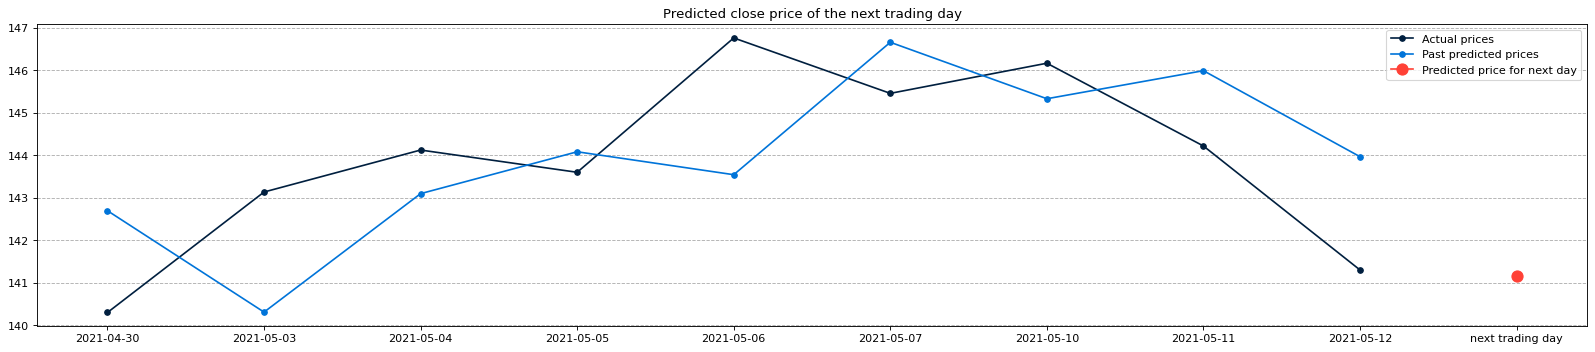

Predicted close price of the next trading day: 141.17


In [11]:
# predict on the unseen data, tomorrow's price 

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()
prediction = scaler.inverse_transform(prediction)[0]

if config["plots"]["show_plots"]:
        
    # prepare plots

    plot_range = 10
    to_plot_data_y_val = np.zeros(plot_range)
    to_plot_data_y_val_pred = np.zeros(plot_range)
    to_plot_data_y_test_pred = np.zeros(plot_range)

    to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
    to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

    to_plot_data_y_test_pred[plot_range-1] = prediction

    to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
    to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

    # plot

    plot_date_test = data_date[-plot_range+1:]
    plot_date_test.append("next trading day")

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
    plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
    plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
    plt.title("Predicted close price of the next trading day")
    plt.grid(b=None, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

print("Predicted close price of the next trading day:", round(prediction, 2))

In this code, the trained LSTM model is used to predict tomorrow's price using unseen data. The unseen data, represented by "data_x_unseen," is prepared for prediction by setting the model to evaluation mode using "model.eval()" to deactivate certain layers that behave differently during training and evaluation. Specifying the device and reshaping it to [batch, sequence, feature] converts it to a torch tensor and transforms it to the required data type and shape. In this case, the batch size is set to 1 and an additional dimension is added to match the expected shape. Predictions are then obtained using the prepared input data. To obtain the predicted price in its original scale, the "inverse_transform" method of the "Normalizer" class is used to transform the prediction into a numpy array. When the "show_plots" flag is set to True in the configuration, the code prepares the data for plotting. Variables are created to store actual prices, predicted prices, and next day's predictions. The data is prepared by inverse-transforming the corresponding data arrays, selecting the desired range, and replacing zero values with None to ensure proper visualization.

To visualize the actual price, predicted price, and forecast price, a plot is then created. Data points are marked with markers and labelled accordingly on the plot. The x-axis is adjusted to display the corresponding dates.

The plot is displayed using "plt.show()".

Finally, the predicted close price for the next trading day is displayed. By using the trained LSTM model, this code predicts tomorrow's price based on unseen data. This tool creates a plot of the predicted price along with the actual price and previous predictions. Also printed is the predicted close price of the next trading day.

The results of this analysis demonstrate that LSTM models can accurately predict stock prices using time series data. We have successfully obtained predictions that closely align with actual stock prices by training the model on historical stock prices and using techniques such as data normalization, windowing, and proper evaluation. By analyzing the model's performance, we can assess how well it captures trends and makes accurate predictions. Stock market forecasting is a complex task, and accurate predictions are affected by a range of factors, such as market volatility, economic conditions, and unforeseen circumstances. The use of LSTM models in stock price prediction remains a promising tool for investors, traders, and researchers seeking valuable insights and making informed decisions. With advancements in deep learning, stock market predictions and investment strategies will become even more accurate and reliable.